In [1]:
import sys
import timeit
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display

sys.path.append('../gmm_modules/')
from data_preparation import get_train_test_data, get_gen_data, get_train_data_for_NN
from metrics import metric_boxplot, eval_metrics, dump_metrics

np.random.seed(10)
%matplotlib inline

** Этапы **

    1) Подготовка датасета (можно вынести и сделать функцию, которая по пути, столбцам, размеру train и test, 
        возвращает X_good, X_bag, X_test, y_test) !!!!!!!! нормально определить кто "0", а кто "1"!!!!!!!!
        - загрузка датасета
        - балансировка
        - разбиваем на train и test сбалансированный
        - разбиваем train по классам
        
    2) Генерация pseudo_neg (можно вынести и сделать функцию, которая по количеству компонент в смеси, 
    сигме, количеству сгенерированных сэмплов, возвращает X_gen, w_gen)
        - обучение gmm на X_good
        - генерация pseudo_neg
        - перевзвешивание их

    3) Графики, дампы, функции для метрик (легко выносится в отдельный файл)
        - график обучения(epoch, loss)
        - график метрик с погрешностями(boxplot)

        - сохранение метрик

        - функции, вычисляющие значения метрик(P@R и его добавление в словарь для разных значений R)
        
    4) Подготовка модели и ее обучение 
        - шаманство с запуском tf + keras на gpu (не вынесешь)
        - построение модели нейронки для обучения (легко выносится в отдельный файл)
        - подготовка данных по "батчам" для обучения (легко выносится в отдельный файл)
        - настройка fracs и количества перезапусков для каждого frac (не вынесешь)
        - сам процесс обучения с вычислением и сохранением метрик + построение графиков по ходу дела (перепилить нормально и часть можно вынести в п.3)

## Подготовим данные

** Этапы **

    1) Подготовка датасета (можно вынести и сделать функцию, которая по пути, столбцам, размеру train и test, 
        возвращает X_good, X_bag, X_test, y_test) !!!!!!!! нормально определить кто "0", а кто "1"!!!!!!!!
        - загрузка датасета
        - балансировка
        - разбиваем на train и test сбалансированный
        - разбиваем train по классам

In [3]:
%%time
path_to_dataset = '../../../SUSY.csv'
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
train_size = 400000
test_size = 100000

X_train, X_test, y_train, y_test = get_train_test_data(path_to_dataset, column_names, train_size, test_size)

CPU times: user 40.7 s, sys: 9.65 s, total: 50.3 s
Wall time: 54.2 s


In [4]:
# split X_train by class
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]  

In [5]:
X_good.shape, X_bad.shape, X_train.shape, X_test.shape

((200000, 18), (200000, 18), (400000, 18), (100000, 18))

## Сгенерируем примеры используя GMM подход

** Этапы **
        
    2) Генерация pseudo_neg (можно вынести и сделать функцию, которая по количеству компонент в смеси, 
    сигме, количеству сгенерированных сэмплов, возвращает X_gen, w_gen)
        - обучение gmm на X_good
        - генерация pseudo_neg
        - перевзвешивание их

In [6]:
%%time
path_to_gen_file = './gen_data/gen_35.npz'
n_components = 35
sigma = 0.01
n_samples = X_good.shape[0] * 5

X_gen, w_gen = get_gen_data(path_to_gen_file, X_good, n_samples, n_components, sigma, recalculate=False)

CPU times: user 196 ms, sys: 224 ms, total: 420 ms
Wall time: 610 ms


In [7]:
X_gen.shape, w_gen.shape, w_gen.sum(), n_samples

((1000000, 18), (1000000,), 1000000.0000000003, 1000000)

Веса ограничены сверху 100. Из этого графика мало что понятно, так как точек слигком много. Можно сказаль лишь то, что около граничных значений весов точек намного больше, чем в середине.

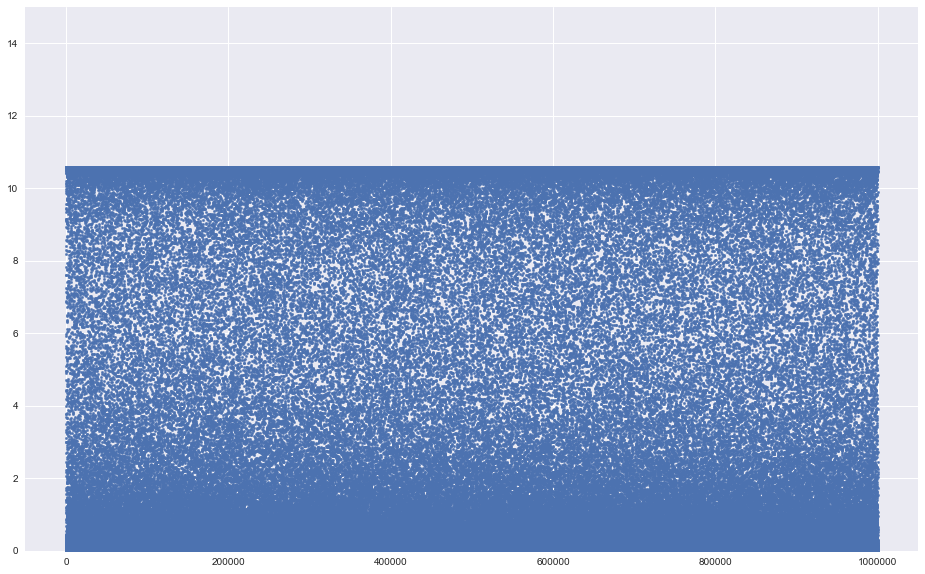

In [13]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(w_gen)), w_gen, s=6)
plt.ylim(0, 15)
plt.show()

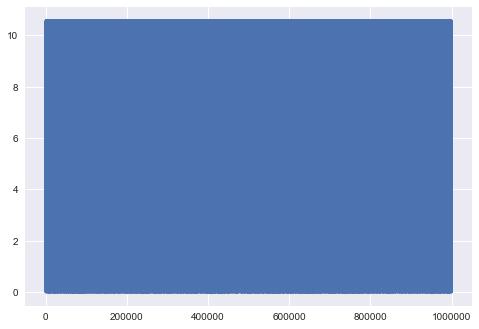

In [14]:
plt.plot(w_gen)
plt.show()

In [15]:
len(w_gen[w_gen>1])/len(w_gen), len(w_gen[w_gen<1])/len(w_gen)

(0.140827, 0.859173)

In [16]:
max(w_gen), min(w_gen)

(10.578099628140878, 1.0921841690517921e-09)

In [17]:
np.mean(w_gen), np.std(w_gen)

(1.0000000000000004, 2.7234509249457326)

## Графики

Строит зависимость ошибок от эпохи

In [18]:
# summarize history for loss
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

## Обучим на этом нейронку

In [19]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

In [20]:
import os
import tensorflow as tf
tf.set_random_seed(1)

import keras
from keras.models import Sequential, Model
from keras import layers as L
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
sess = tf.Session(config=config)
set_session(sess)

Простейшая сверточная сеть для двухклассовой классификации

In [22]:
def build_net():
#     with tf.device('/gpu:2'):
    net = Sequential()
    
    net.add(L.Dense(100, input_shape=(X_good.shape[1],), activation = 'relu'))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.2))
    
    net.add(L.Dense(46, activation='relu'))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.1))
    
    net.add(L.Dense(20, activation='relu'))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.1))
    
    net.add(L.Dense(1, activation='sigmoid'))

    adam = keras.optimizers.Adam(lr=0.0005)
    net.compile(optimizer=adam, loss='binary_crossentropy')
    return net

Подготовка данных по "батчам" для обучения(ПЕРЕМЕШИВАНИЕ УЖЕ СДЕЛАННО!!! ЕЩЕ РАЗ НЕЛЬЗЯ, ИБО ВЕСА В ЛОССЕ ПОЕДУТ)

Настройка текущей конфигурации запуска

In [42]:
metrics_dict = {
    'pr_aucs' : {},
    'roc_aucs' : {},
    'p_at_r' : {
        '0.8': {},
        '0.9': {}, 
        '0.95': {},
        '0.99': {},
    }
}

In [43]:
fraction_of_negative_used = np.array([0.001, 0.01, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.array([20, 20, 20, 20, 4, 4, 4, 4, 4])
n_evals_for_frac = np.zeros_like(fraction_of_negative_used)

In [46]:
alpha = 0.1
metrics_path = './metrics/our/alpha_' + str(alpha)
batch_size = 256 * 3
n_epochs = 20

# weights
w_good = np.ones(X_good.shape[0])
w_bad = np.ones(X_bad.shape[0])

Обучим нейронку с нашими весами

Run time: 2427.66 sec
PR_AUC:  (0.0001, 0.8079736972268353)
ROC_AUC:  (0.0001, 0.7880126578)
alpha:  0.1
n_evals_for_frac:  [6. 5. 4. 4. 4. 4. 4. 4. 4.]


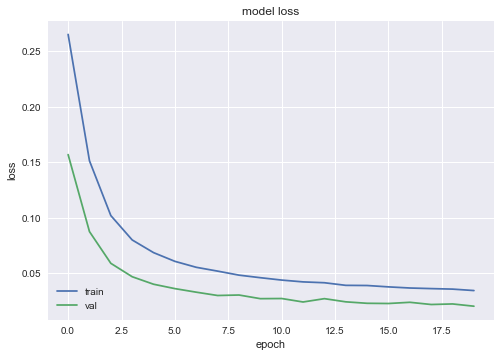

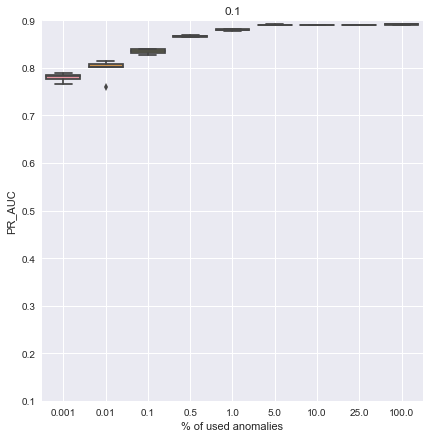

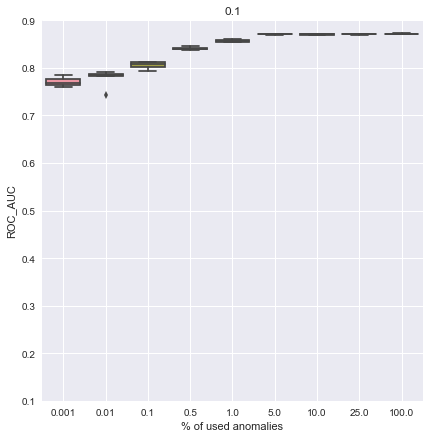

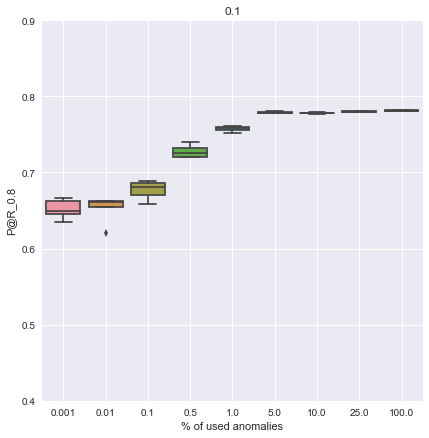

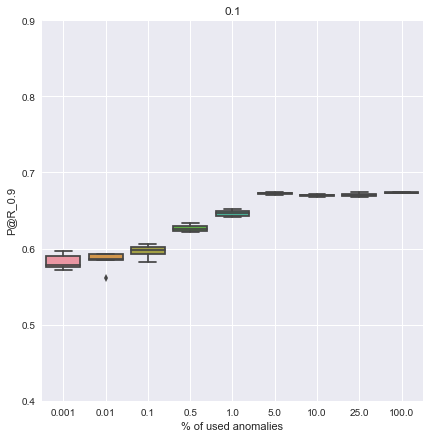

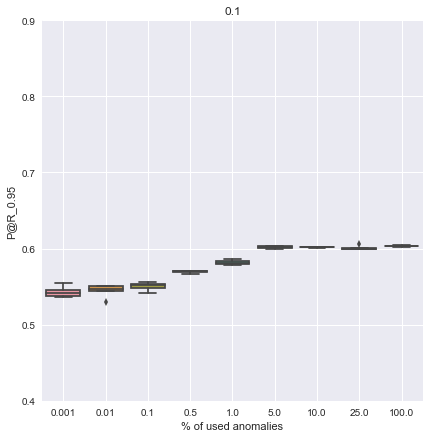

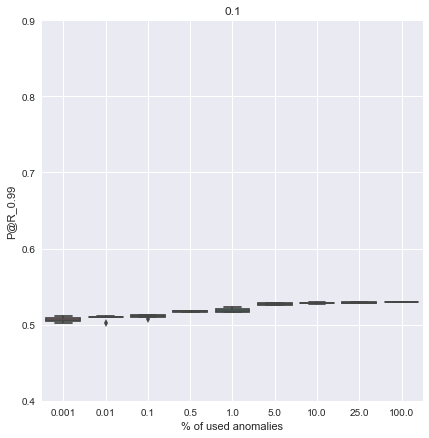

2it [1:20:38, 2407.85s/it]

In [ ]:
%%time
while np.sum(n_resplits - n_evals_for_frac) > 0:
    for i, frac in tqdm(enumerate(fraction_of_negative_used)):
        if n_evals_for_frac[i] >= n_resplits[i]:
            continue
            
        # prepare data
        if frac > 1:
            end_ind = X_good.shape[0]
        else:   
            end_ind = int(X_good.shape[0] * frac)

        idx_good = np.random.permutation(X_good.shape[0])
        idx_bad = np.random.permutation(X_bad.shape[0])
        idx_gen = np.random.permutation(X_gen.shape[0])
            
        cur_X, cur_y, cur_w = get_train_data_for_NN(
            X_good[idx_good], X_bad[idx_bad[:end_ind]], X_gen[idx_gen],
            w_good[idx_good], w_bad[idx_bad[:end_ind]], w_gen[idx_gen], batch_size, alpha
        )
        
        # fit model and predict probas
        start_time = timeit.default_timer()
        net = build_net()
        history = net.fit(cur_X, cur_y, sample_weight=cur_w,
                          batch_size=batch_size, epochs=n_epochs, validation_split=0.1, verbose=0)
        y_pred=net.predict_proba(X_test)
        run_time = timeit.default_timer() - start_time
        
        # eval and save metrics
        eval_metrics(y_test, y_pred, frac, metrics_dict, descr=alpha)
        dump_metrics(metrics_path, metrics_dict)
        n_evals_for_frac[i] += 1

        # print info
        display.clear_output(wait=True)
        print("Run time: {:.2f} sec".format(run_time))
        print("PR_AUC: ", metrics_dict['pr_aucs'][alpha][-1])
        print("ROC_AUC: ", metrics_dict['roc_aucs'][alpha][-1])
        print('alpha: ', alpha)
        print('n_evals_for_frac: ', n_evals_for_frac)
        
        # plot metrics
        history_plot(history)
        metric_boxplot(metrics_dict['pr_aucs'], ylabel='PR_AUC', ylim=(0.1, 0.9))
        plt.show()
        metric_boxplot(metrics_dict['roc_aucs'], ylabel='ROC_AUC', ylim=(0.1, 0.9))
        plt.show()
        for k in metrics_dict['p_at_r'].keys():
            metric_boxplot(metrics_dict['p_at_r'][k], ylabel='P@R_' + str(k), ylim=(0.4, 0.9))
            plt.show()